In [2]:
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt
from spKMC import *
from spKMC_unitTests import *
from spKMC_sampling import *
from model_observation import *
import os
import json
plt.rcParams.update({'font.size': 25})

Here we show some examples of how to simulate SEIR dynamics on a network, and on an ensemble of networks. We then show how one may correct for noise in measurements to extract the true number of infectious by performing 1)mean field corrections, and 2)Bayesian corrections. 

These codes are a part of work described in the paper 
Vasiliauskaite, V., Antulov-Fantulin, N., & Helbing, D. (2022). On some fundamental challenges in monitoring epidemics. Philosophical Transactions of the Royal Society A, 380(2214), 20210117.


# Simulations of dynamics

## A network
A first step is to generate a network. Here we generate a network with a power-law degree distribution ("Barabasi-Albert" network). Any graph suffices, however the input to the epidemic model needs to be a directed network, therefore the last step in the following cell is to turn the undirected graph g into a directed graph g_spkmc.

In [8]:
N = 0.5*10**3 #size of the network
m,gamma = 3,1 # network model parameters
network_param_label = f"price_network_m_{m}_gamma_{gamma}" #network name 
g_lambda = lambda N: gt.price_network(N, m, gamma, directed=False) #define a network ensemble
g = g_lambda(N) #generate a network
g_spkmc = generate_directed_graph(g) #turn an undirected network to a directed network
print(g_spkmc.is_directed())

True


## Simulations of epidemic dynamics
Next we simulate the dynamics on the network g_spkmc. The epidemic dynamics has three parameters: $\alpha, \beta,\gamma$ that we define here. We also need to define the observation time, the number of simulations of dynamics, and the number of initial sources.

In [15]:
epi_params = {"alpha":1/5, "beta": 3/14,"gamma":1/14} #epidemic parameters
T = 100 #total time of observation
t_array = list(range(T))
num_sim = 1 # number of epidemic simulations to do
num_sources = 1 #number of source nodes
ensemble_epi_trajectories = sample_epi_trajectories(g_spkmc, N, num_sim, num_sources, epi_params, T)
X = ensemble_epi_trajectories["I"]

0.0% 

In [16]:
ensemble_epi_trajectories

{'S': array([[499., 496., 490., 480., 470., 443., 415., 381., 344., 303., 266.,
         226., 195., 165., 144., 114.,  98.,  73.,  63.,  49.,  40.,  31.,
          25.,  21.,  13.,  10.,   9.,   9.,   8.,   7.,   6.,   5.,   3.,
           3.,   3.,   3.,   3.,   3.,   3.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,
           2.]]),
 'E': array([[  1.,   3.,   9.,  16.,  21.,  41.,  59.,  83., 105., 127., 146.,
         154., 153., 143., 136., 141., 129., 139., 124., 108.,  99.,  87.,
          71.,  60.,  52.,  43.,  34.,  28.,  24.,  22.,  21.,  19.,  18.,
          16.,  14.,  10.,   9.,   6.,   6.,   7.,   7.,   5.,   3.,   2

Instead of relying on a single network, we can also sample trajectories from multiple networks in some network ensemble g_lambda.

In [18]:
num_sim = 1 # number of epidemic simulations to do
num_sources = 1 #number of source nodes
num_sim_network = 10 #number of networks to sample 
sample_epi_ensemble = sample_epi_trajectories_multi_rnd_sources_ensemble(g_lambda, N, \
                                                        num_sim_network, num_sources, epi_params, T)
print(sample_epi_ensemble)

0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% {'S': array([[499., 499., 499., 499., 499., 499., 499., 499., 496., 494., 492.,
        490., 487., 483., 476., 472., 465., 447., 431., 413., 386., 354.,
        324., 302., 275., 235., 204., 176., 145., 123., 104.,  84.,  68.,
         57.,  51.,  41.,  35.,  29.,  22.,  20.,  17.,  16.,  14.,  13.,
         13.,  11.,   9.,   8.,   8.,   8.,   8.,   7.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.],
       [499., 499., 499., 499., 499., 499., 499., 497., 496., 496., 492.,
        478., 454., 443., 424., 392., 356., 319., 283., 240., 206., 169.,
        137., 113.,  88.,  59.,  43.,  33.,  30.,  24.,  24.,  18.,   9.,
          8.,   8.,   6.,   3., 

# Simulations of a testing procedure
In reality, the true numbers of infectious individuals are not available. Instead, we have the number of individuals that we tested, and some of the tested individuals the tests returned as positive. However, all tests have the false positive rate, and a false negative rate. There is also bias in the testing procedure: we usually test the people with symptoms. Therefore, if we simply extrapolated the fraction of positive tests out of all perfomed tests to the fraction of infectious individuals nationwide, we would be widely over-estimating the state of the epidemic.

Here we simulate a "testing procedure", with known false positive and false negative rates (FPR, FNR) and we have some bias towards testing symptomatic individuals: 5% of tests are administered to people with no symptoms.

In [19]:
# =======================================
# Testing parameters
# =======================================
X_hat = np.zeros(X.shape)
N_tests = np.zeros(X.shape)

(A_i,B_i) = (4,16)
Q_i = A_i/(A_i+B_i)

A_h = 5;
B_h = 95;
Q_h = A_h/(A_h+B_h)


A_FPR,B_FPR = 10,90
FPR = A_FPR/(A_FPR+B_FPR)

A_FNR,B_FNR = 5,95
FNR = A_FNR/(A_FNR+B_FNR)


# =======================================
# Testing procedure
# =======================================
for t in range(0, T):
    for i in range(num_sim):
        X_true= X[i,t]
        Tests_I = int(Q_i * X_true)
        Tests_H = int(Q_h * (N - X_true))
        N_tests[i,t]=Tests_I + Tests_H
        N_I_calc, ntests_I_calc = calc_infected(n__ = int(X_true), T__ = Tests_I, R__ = 1 - FNR)
        N_H_calc, ntests_H_calc =calc_infected(n__ = int(N - X_true), T__ = Tests_H, R__ = FPR)
        X_hat[i,t] = N_I_calc + N_H_calc


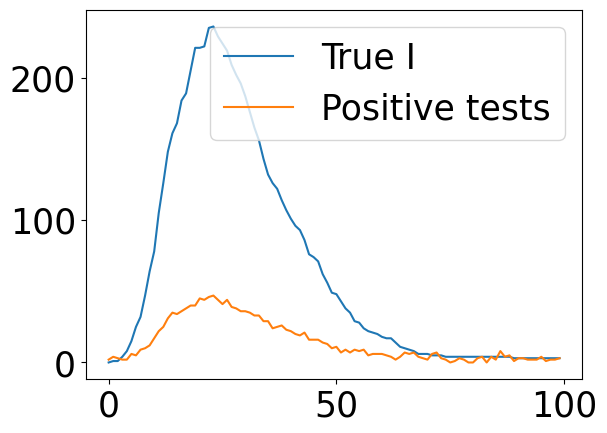

In [25]:
plt.plot(X[0],label="True I")
plt.plot(X_hat[0], label = "Positive tests")
plt.legend()

## Corrections

Two possible corrections are possible: Mean-field, or Bayesian corrections. In the mean-field correction, we assume that we know the measurement errors and biases pretty accurately, whereas in Bayesian correction, we relax this constraint.

For instance, consider the mean-field correction where we know the measurement parameters defined above perfectly, and another correction where we over-estimate the fraction of healthy individuals that are tested, Q_h.

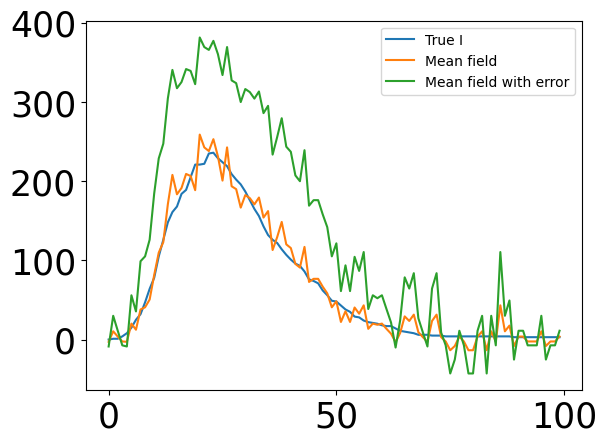

In [36]:
# =======================================
# Mean field correction 
# =======================================
mean_field = calc_correction(Q_i__ = Q_i, Q_h__ = Q_h, N__ = N, n_tests__ = N_tests, k__ = X_hat,\
                                     FPR__ = FPR, FNR__ = FNR)[0]

mean_field_with_error = calc_correction(Q_i__ = Q_i, Q_h__ = Q_h +0.1, N__ = N, n_tests__ = N_tests, k__ = X_hat,\
                                     FPR__ = FPR , FNR__ = FNR)[0]
plt.plot(X[0],label="True I")
plt.plot(mean_field, label = "Mean field")
plt.plot(mean_field_with_error, label = "Mean field with error")
plt.legend(fontsize =10, loc= 1)

Clearly, to use the mean-field correction, we need to know the measurement parameters pretty acurately. Alternatively, we need to do more sophisticated corrections, such as Bayesian correction.

In [27]:
# =======================================
# Bayesian correction 
# =======================================

num_sim_network = 10
sample_epi_ensemble = sample_epi_trajectories_multi_rnd_sources_ensemble(g_lambda, N, \
                                                        num_sim_network, num_sources, epi_params, T)
network_sample = False # if perofrm network brior
if network_sample == True:
    delta= 5 #half the time window to consider for network prior
else:
    delta = np.nan
FPR_sample = True # if perform sampling for FPR
FNR_sample = True # if perform sampling for FNR
Q_i_sample = True # if perform sampling for Q_i
Q_h_sample = True # if perform sampling for Q_h
I_hat= np.zeros_like(X) #for storage of the Bayesian estimate
M = 10 # number of samples to estimate posterior


for t in range(X_hat.shape[1]):
    for sim in range(X_hat.shape[0]):
        k = X_hat[sim,t]
        nt = N_tests[sim,t]
        if network_sample == True:
            prior_distr = get_prior_distr( f(t-delta), t+delta, sample_epi_ensemble["I"], int(N))
        else:
            prior_distr = np.ones(int(N))
        I_est = posterior_estimate(I_list__ = np.array(range(0,int(N))), 
                                   k__ = k, 
                                   n_tests__ = nt, 
                                   N__ = N, 
                                   A_FPR__ = A_FPR, B_FPR__ = B_FPR, FPR_sample__ = FPR_sample, 
                                   A_FNR__ = A_FNR, B_FNR__ = B_FNR, FNR_sample__ = FNR_sample,
                                   A_i__ = A_i, B_i__ = B_i, Q_i_sample__ = Q_i_sample, 
                                   A_h__ = A_h, B_h__ = B_h, Q_h_sample__ = Q_h_sample,
                                   network_prior__ = prior_distr, M__ = M) 
        I_hat[sim,t] = I_est

0.0% 10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 

## Plotting and saving data

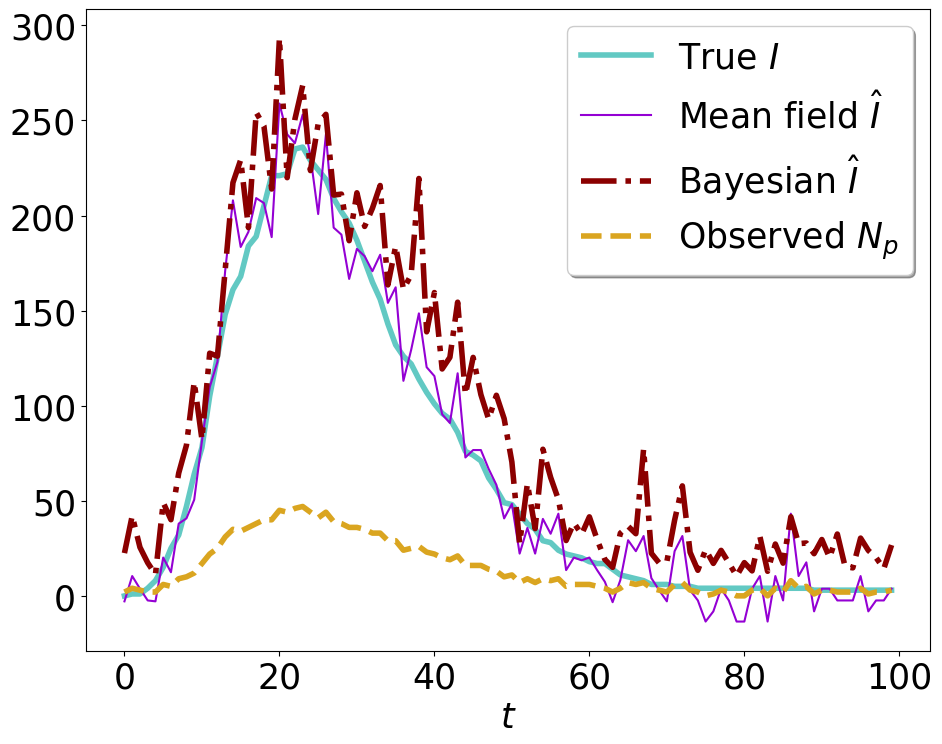

In [32]:
fig,ax =plt.subplots( figsize =(10,8))
ax.plot(t_array,(X.mean(0)),alpha = 0.7,linewidth=4,label = "True $I$",color="lightseagreen")
ax.plot(t_array,mean_field,color="darkviolet", label = "Mean field $\hat{I}$")
ax.plot(t_array,I_hat.mean(0), label ="Bayesian $\hat{I}$",c="darkred",linewidth=4,linestyle = "-.")
ax.plot(t_array,X_hat[0], label ="Observed $N_p$",c="goldenrod",linewidth=4,linestyle ="--")
ax.set_xlabel("$t$")   
ax.legend(loc=1,ncol=1,shadow=True)
plt.tight_layout()
name = "name_of_directory"
os.mkdir(f"./results/simu_{name}")
plt.savefig(f"./results/simu_{name}/SEIR_measurement_reconstruction.pdf")


param_dict = {"epi_params": epi_params, "T": T, "N": N, "num_sim": num_sim,
              "num_sources": num_sources, 
              "network_param_label": network_param_label, 
              "num_sim_network": num_sim_network,#, 
              "delta": delta, "FPR_sample": FPR_sample, 
              "FNR_sample": FNR_sample, "Q_i_sample": Q_i_sample,
              "Q_h_sample": Q_h_sample,"M": M,"A_i": A_i,"A_h": A_h, 
              "A_FPR": A_FPR,"B_FPR": B_FPR, "A_FNR": A_FNR , "B_FNR": B_FNR}
    
with open(f'./results/simu_{name}/parameters.json', 'w') as fp:
    json.dump(param_dict, fp)

np.save(f"./results/simu_{name}/mean_field.npy",mean_field)
np.save(f"./results/simu_{name}/I_hat.npy",I_hat)
np.save(f"./results/simu_{name}/X_hat.npy",X_hat)
np.save(f"./results/simu_{name}/X.npy",X)